<center>

*******************************************************************************************

### REDUCED RECTIFIED
### MULTIGRANULAR SEGMENTATION
### OF MEAN ABSOLUTE DEVIATION
  
#####  22 May 2024

##### Juan Ignacio Mendoza Garay  

*******************************************************************************************

</center>

#### INFORMATION:


* Description:

    Compute multigranular aligned segments of the mean absolute deviation (L2-norm), of a
    multi-dimensional time-series or otherwise ordered data in a CSV file. <br>
    More information in Mendoza et al. (2022) https://doi.org/10.5281/zenodo.7243875
  
* Instructions:

    Edit the values indicated with an input_arrow like this: <---  
    Comment/uncomment or change values as suggested by the comments.  
    Run the program, close your eyes and hope for the best.  

*******************************************************************************************


In [10]:
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil, floor
from timeit import default_timer as timer
from scipy.signal import find_peaks, resample
from scipy.spatial.distance import pdist, squareform

***
## Path & parameters

In [11]:
src_data_folder = r"C:\Users\namespace\Documents\Data\SPHERE_data" # <--- full path where CSV input files are (prepend r)
src_data_fn = 'SPHERE_raw_accel_001.csv' # <--- name of CSV input data file with extension

delete_col = 0 # <--- [int] = remove this column, empty = don't. Often useful to get rid of an index (e.g., timestamp)

length_limit = 2000 # <--- length limit to prevent taking too much time. If necessary to reduce size, equally-sized chunks will be averaged.
ksf = range(6,26,2) # <--- novelty kernel size factors respect to total length
pkt = 0.2 # <--- novelty peak threshols (determines segementation boundaries) in [0...1]
max_n_gran = 3 # <--- maximum number of granularity levels (less than number of novelty kernels)

vis_opt = 1 # <--- 1 = show visualisations, 0 = don't
raw_plt_lw = 0.08 # <--- line width for plot of raw data
red_plt_lw = 0.25 # <--- line width for plot of reduced data

# "SPHERE_raw_accel_001.csv" (originally data/raw/001/accel.csv) was taken from
# Tonkin et al. (2022) https://doi.org/10.5523/bris.2h0wyctxrd69j2oqccsi45hy1p

***
## Open CSV file and reduce data

CSV file loaded


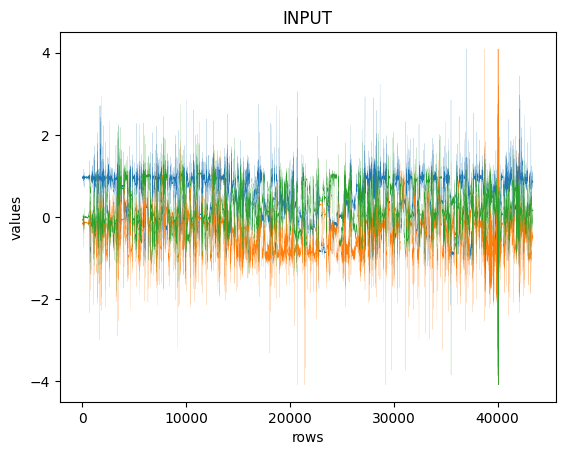

In [12]:
full_src_fn = src_data_folder+'\\'+src_data_fn
data_df = pd.read_csv(full_src_fn)

if isinstance(delete_col,int):
    data_df.drop(data_df.columns[delete_col], axis=1, inplace=True)

if vis_opt:

    plt.plot(data_df,linewidth=raw_plt_lw)
    plt.title('INPUT')
    plt.xlabel('rows')
    plt.ylabel('values')

print('CSV file loaded')


raw data length = 43423
reduced data length = 1973


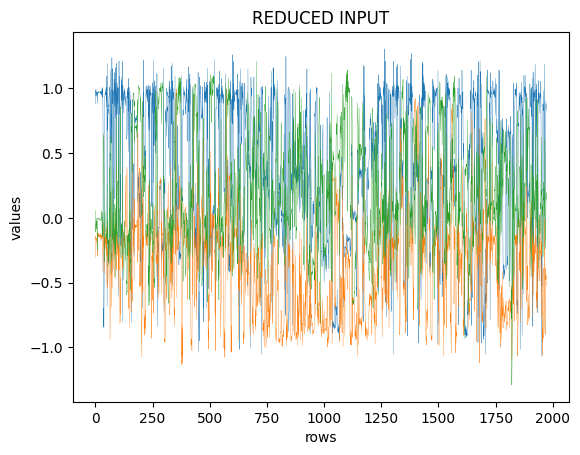

In [13]:
print('raw data length = '+str(data_df.shape[0]))
rf = ceil(data_df.shape[0] / length_limit)
if rf > 1:

    data_arr = resample(data_df.to_numpy(), int(len(data_df)/rf) )
    print('reduced data length = '+str(len(data_arr)))

    if vis_opt:

        plt.plot(data_arr,linewidth=red_plt_lw)
        plt.title('REDUCED INPUT')
        plt.xlabel('rows')
        plt.ylabel('values') 
    
else:
    data_arr = data_df.to_numpy()
    print('data was not reduced')
    

***
## Reduced and rectified multigranular segmentation boundaries

In [14]:
def rrmg_seg(input_arr,nks_l,sdf,pkt,max_n_gran):

    """
    Computes rectfied reduced multigranular segmentation.
    
    INPUT:
        input_arr: [numpy array] input data (one data-point per row)
        nks_l: [int or list] even integers, sizes of novelty kernels
        sdf: [int] proportion of the kernel for the standard deviation of the Gaussian taper
        pkt: [float] novelty peak threshold (determines segmentation boundary) in [0...1]

    OUTPUT:
        red_rect_seg_idx_nl: [nested list] indices of the rectified segment boundaries
        rect_seg_idx_nl: [nested list] indices of the rectified segment boundaries
        seg_idx_nl: [nested list] indices of the raw segment boundaries
        nov_mtx: [numpy array] matrix of raw novelty scores
        snov_mtx: [numpy array] matrix of gaussian-filtered novelty scores rescaled to [0,1]
        dist_m: [numpy array] the distance matrix
    """

    for nk_size in nks_l:
    
        if nk_size%2: # == odd
            raise Exception('Error: nk_sizes should be an even number.')
            
    def gausswin(size,sd):
            x = np.linspace(-int(size/2),int(size/2),size)
            return 1. / np.sqrt( 2. * np.pi * sd**2 ) * np.exp( -x**2 / ( 2. * sd**2 ) )
            
    dist_m = squareform( pdist( np.column_stack( (input_arr, input_arr) ) , 'euclidean') )

    n_nk = len(nks_l)
    nov_mtx = np.zeros([ n_nk , input_arr.shape[0] ])
    snov_mtx = np.copy(nov_mtx)
    seg_idx_nl = []

    mtx_row = 0
    for nk_size in nks_l:

        # Novelty (Foote, 2000):
        sd = nk_size/sdf # kernel's gaussian taper standard deviation
        kernel_size_half = int(nk_size/2)
        xx = np.linspace(-kernel_size_half,kernel_size_half,nk_size)
        yy = np.linspace(-kernel_size_half,kernel_size_half,nk_size)
        xx, yy = np.meshgrid(xx, yy)
        gauss_2D = 1. / (2. * np.pi * sd**2) * np.exp(-(xx**2. / (2. * sd**2.) + yy**2. / (2. * sd**2.)))
        kron_cb = np.kron( [[-1,1],[1,-1]] , np.ones( (kernel_size_half,kernel_size_half) ) )
        gausscb_kernel = gauss_2D * kron_cb
        for i_start in np.arange(0,input_arr.shape[0]-nk_size):
            i_end = i_start + nk_size
            nov_mtx[ mtx_row, i_start + kernel_size_half ] = np.sum( gausscb_kernel * dist_m[ i_start:i_end , i_start:i_end ] )

        # Gaussian filter: 
        gf_size = int(nk_size/4)
        if gf_size%2: # == odd
            gf_size += 1
        gf_sd = int(gf_size/4)
        gaussian_window =  gausswin(gf_size,gf_sd)
        snov_mtx[mtx_row] = np.convolve(nov_mtx[mtx_row], gaussian_window, mode="same")

        mtx_row += 1

    # Normalise it, don't criticise it:
    snov_mtx = snov_mtx - np.min(snov_mtx)
    snov_mtx = snov_mtx / np.max(snov_mtx)
    
    mtx_row = 0
    for nk_size in nks_l:
  
        # Peaks (segment boundaries):
        pks_idx = find_peaks(snov_mtx[mtx_row])[0]
        pks_val = np.array(list(zip(pks_idx, snov_mtx[mtx_row][pks_idx])))        
        seg_idx_nl.append( [ index for index, value in pks_val if value > pkt] ) # index of peaks over threshold

        mtx_row += 1

    # Rectification:
    if n_nk == 1:

        rect_seg_idx_nl = seg_idx_nl
    else:
        end = n_nk -1
        tolerance = floor(min( np.diff(seg_idx_nl[end]) ) / 2 - 1)
        if tolerance < 0:
            tolerance = 0
        rect_seg_idx_nl = []
        rect_seg_idx_nl.append(copy.deepcopy(seg_idx_nl[end]))
        rect_seg_idx_nl[0] = [int(x) for x in rect_seg_idx_nl[0]]
    
        for i_rect_b in range(len(seg_idx_nl[end])):
        
            rect_b = seg_idx_nl[end][i_rect_b]
            i_seg_col = i_rect_b
            i_seg_row = end
            i_rect_row = 1
            keep_going = True
        
            while (keep_going == True) and (i_seg_row >= 0):
                
                this_b = seg_idx_nl[i_seg_row][i_seg_col]
                
                # this could be more efficient if search was not done on items visited in previous iterations:        
                other_i_arr = np.where(( seg_idx_nl[i_seg_row - 1] < (this_b+tolerance) ) & ( seg_idx_nl[i_seg_row - 1] > (this_b-tolerance) ))[0]
        
                i_seg_row -= 1
                
                if other_i_arr.size > 0:
        
                    if i_rect_row >= len(rect_seg_idx_nl):
                        rect_seg_idx_nl.append([])
                    rect_seg_idx_nl[i_rect_row].append(int(rect_b))
                    i_rect_row += 1
                    i_seg_col = other_i_arr[0]
                else:
                    keep_going = False
                
    rect_seg_idx_nl.reverse()   

    for i_gran_b in range(n_nk):
        seg_idx_nl[i_gran_b] = [int(x) for x in seg_idx_nl[i_gran_b]]

    # Reduction:
    if max_n_gran >= n_nk:
        raise Exception("Maximum number of granularity levels should be less than number of novelty kernels.")

    if n_nk in [1,2] :
    
        red_rect_seg_idx_nl = copy.deepcopy(rect_seg_idx_nl)
    else:
        L = ( list(len(x) for x in rect_seg_idx_nl))
        dL = np.diff(L)
        dLc = [(dL[i]+dL[i+1]) for i in range(len(dL)-1)]
        i_rank = np.argsort(dLc)
        i_sel_no_ex =  np.sort( i_rank[ len(i_rank) - max_n_gran  + 2: len(i_rank) ]) + 1 
        i_keep = [0]
        i_keep.extend([i for i in i_sel_no_ex])
        i_keep.append(len(rect_seg_idx_nl)-1)
        red_rect_seg_idx_nl = [rect_seg_idx_nl[i] for i in i_keep]
    
    return red_rect_seg_idx_nl, rect_seg_idx_nl, seg_idx_nl, nov_mtx, snov_mtx, dist_m


REDUCED RECTIFIED MULTIGRANULAR SEGMENTATION computation time: 1.92296 s.


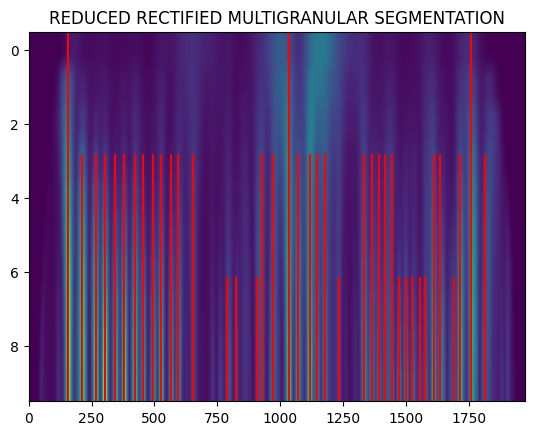

In [15]:
nks_l = []
n_data = len(data_arr)
for this_ksf in ksf:
    val = int(np.floor(n_data/this_ksf))
    if val%2:
        val += 1
    nks_l.append(val)    

tic = timer()
red_rect_seg_idx_nl, _, _, _, snov_mtx, dist_m = rrmg_seg(data_arr,nks_l,4,pkt,max_n_gran)
toc =  timer() - tic

print( 'REDUCED RECTIFIED MULTIGRANULAR SEGMENTATION computation time: %0.5f s.' % toc )

n_gran = len(red_rect_seg_idx_nl)

if vis_opt:
    
    plt.imshow(snov_mtx, aspect="auto")
    plt.title('REDUCED RECTIFIED MULTIGRANULAR SEGMENTATION')
    axes = plt.gca()
    ylim = axes.get_ylim()
    ystep = 1/n_gran
    ymax = 1
    for i in range(n_gran):
        ymin = ymax-ystep
        for x in red_rect_seg_idx_nl[i]:
            plt.axvline(x, ymin, ymax, color = 'r')
        ymax -= ystep

***
## MAD segmentation

In [16]:
# Mean Absolute Deviation (MAD)
# Array columns are: gran. level 1 length, gran. level 1 MAD, gran. level 2 length, gran. level 2 MAD, etc.
# Empty cells are nan.

data_norm = np.linalg.norm(data_arr, axis = 1)

n_segm = []
MAD_seq = np.empty([len(red_rect_seg_idx_nl[-1])+1,n_gran*2])
MAD_seq[:] = np.nan
i_gran_s = -1

for i_gran_b in range(n_gran-1,-1,-1):

    n_segm.append(len(red_rect_seg_idx_nl[i_gran_b])+1)

    i_gran_s += 1 
    i_col_length = i_gran_s * 2
    i_col_MAD = i_col_length + 1

    MAD_seq[0,i_col_length] = red_rect_seg_idx_nl[i_gran_b][0]
    this_diff_v = np.diff(red_rect_seg_idx_nl[i_gran_b])
    MAD_seq[-1,i_col_length] = n_data - red_rect_seg_idx_nl[i_gran_b][-1]

    i_n_start = int( red_rect_seg_idx_nl[i_gran_b][-1] )
    MAD_seq[-1,i_col_MAD] = np.mean( data_norm[i_n_start:-1] )
    
    i_n_end = int( red_rect_seg_idx_nl[i_gran_b][0] )
    MAD_seq[0,i_col_MAD] = np.mean( data_norm[0:i_n_end] )
    i_n_start = i_n_end
    i_seq = 1

    if i_gran_b == n_gran-1:
        
        MAD_seq[1:-1,i_col_length] = this_diff_v

        for i_b_this_gran in range(1,n_segm[i_gran_s]-1):

            i_n_end = int( red_rect_seg_idx_nl[i_gran_b][i_b_this_gran] )
            MAD_seq[i_seq,i_col_MAD] = np.mean( data_norm[i_n_start:i_n_end] )
            i_n_start = i_n_end
            i_seq += 1
    else:

        i_b_this_gran = 1
        i_b_first_gran = 1
        i_diff = 0

        while i_b_this_gran <= (n_segm[i_gran_s]-2):

            MAD_seq[i_seq,i_col_length] = this_diff_v[i_diff]
        
            i_n_end = int( red_rect_seg_idx_nl[i_gran_b][i_b_this_gran] )
            MAD_seq[i_seq,i_col_MAD] = np.mean( data_norm[i_n_start:i_n_end] )
            i_n_start = i_n_end

            if red_rect_seg_idx_nl[i_gran_b][i_b_this_gran] == red_rect_seg_idx_nl[-1][i_b_first_gran] : # you won't know until you begin

                i_seq += 1
                i_b_first_gran += 1
                                
            else: # might as well jump
                i_b_first_gran = 1 + i_b_first_gran + red_rect_seg_idx_nl[-1][i_b_first_gran:].index(red_rect_seg_idx_nl[i_gran_b][i_b_this_gran])
                i_seq = i_b_first_gran

            i_diff += 1
            i_b_this_gran += 1


In [17]:
# Normalise it, don't criticise it:
MAD_min = np.inf
MAD_max = -np.inf # yea, that movie
rescale_max = 2**7 - 1 # yea, MIDI
for bound_kind in ["min","max"]:
    for action_kind in ["get","set"]:
        for i_gran_s in range(n_gran):
            i_col_MAD = (i_gran_s * 2) + 1 
            if action_kind == "get":
                if bound_kind == "min":
                    this_min = np.nanmin( MAD_seq[:,i_col_MAD] )
                    if this_min < MAD_min:
                        MAD_min = this_min
                elif bound_kind == "max":
                    this_max = np.nanmax( MAD_seq[:,i_col_MAD] )
                    if this_max > MAD_max:
                        MAD_max = this_max            
            if action_kind == "set":
                if bound_kind == "min":
                    MAD_seq[:,i_col_MAD] = MAD_seq[:,i_col_MAD] - MAD_min
                elif bound_kind == "max":
                    MAD_seq[:,i_col_MAD] = (MAD_seq[:,i_col_MAD] / MAD_max) * rescale_max 
MAD_seq = MAD_seq.astype('float16')

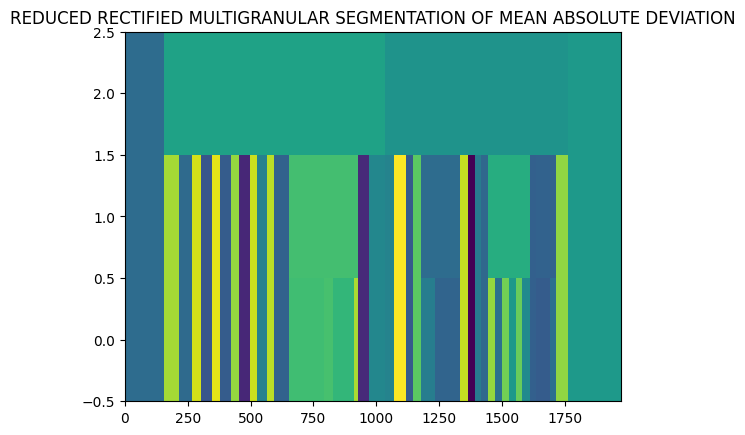

In [18]:
# Heatmap of the segmented MAD:

MAD_map = np.zeros([n_gran,n_data],'uint8')

for i_gran_s in range(n_gran):
    
    i_col_length = i_gran_s * 2
    i_col_MAD = i_col_length + 1
    i_seq = 0
    i_start = 0
    i_segm = 0
    
    while i_segm <= n_segm[i_gran_s]-1:

        if np.isnan(MAD_seq[i_seq,i_col_MAD]): # go ahead and jump
            
            i_seq = i_seq + np.argmax(~np.isnan(MAD_seq[i_seq:,i_col_MAD]))
            
        i_end = i_start + int( MAD_seq[i_seq,i_col_length] )
        MAD_map[i_gran_s,i_start:i_end] = MAD_seq[i_seq,i_col_MAD]
        i_start = i_end
        i_seq += 1        
        i_segm += 1

if vis_opt:
    
    plt.imshow(MAD_map, aspect='auto',interpolation='none',origin="lower")
    plt.title('REDUCED RECTIFIED MULTIGRANULAR SEGMENTATION OF MEAN ABSOLUTE DEVIATION')


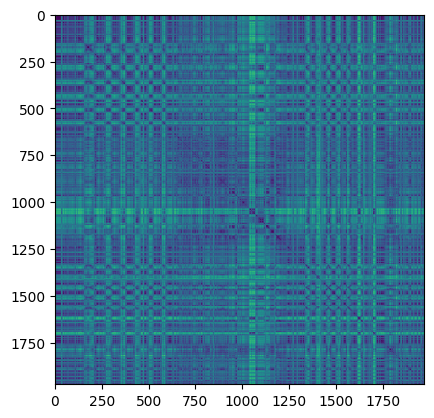

In [19]:
# Just to double-check, a heatmap of the self-similarity matrix:

if vis_opt:
    plt.imshow(dist_m)
